# EE551

# Linear Systems, frequency domain and restoration

### Import libraries

In [1]:
%matplotlib inline 
from PIL import Image
from skimage.io import imread, imshow, show
import scipy.fftpack as fp
from scipy import ndimage, misc, signal
from skimage import data, img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale
import matplotlib.pylab as pylab
import numpy as np
import numpy.fft
import timeit
from math import log10, sqrt

## Helper Functions

In [2]:
def plot_image(image, title=''):
    pylab.title(title, size=20), pylab.imshow(image)
    pylab.axis('off') # comment this line if you want axis ticks
    
def compare_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

### Image restoration

In [20]:
im = 255*rgb2gray(imread('../images/lena.jpg'))

gauss_kernel = np.outer(signal.gaussian(im.shape[0], 3),
signal.gaussian(im.shape[1], 3))
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel)) # this is our H
convolved = freq*freq_kernel # by convolution theorem
im_blur = fp.ifft2(convolved).real
im_blur = 255 * im_blur / np.max(im_blur) # normalize

#im_blur += 0.001 * im_blur.std() * np.random.standard_normal(im_blur.shape)

243.83080000000004 255.0


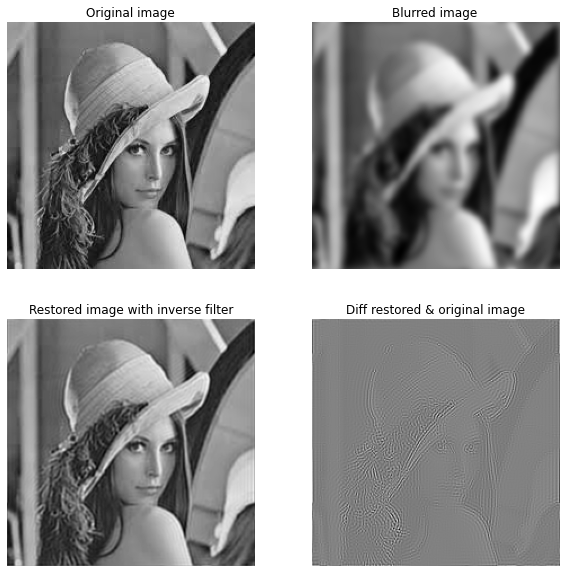

In [21]:
epsilon = 10**-6
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel) # avoid division by zero
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = 255 * im_restored / np.max(im_restored)
print(np.max(im), np.max(im_restored))
pylab.figure(figsize=(10,10))
pylab.gray()
pylab.subplot(221), pylab.imshow(im), pylab.title('Original image'), pylab.axis('off')
pylab.subplot(222), pylab.imshow(im_blur), pylab.title('Blurred image'), pylab.axis('off')
pylab.subplot(223), pylab.imshow(im_restored), pylab.title('Restored image with inverse filter'), pylab.axis('off')
pylab.subplot(224), pylab.imshow(im_restored - im), pylab.title('Diff restored & original image'), pylab.axis('off')
pylab.show()

### Define Motion Blur kernel

In [5]:
kernel_size = 21 # a 21 x 21 motion blurred kernel
mblur_kernel = np.zeros((kernel_size, kernel_size))
mblur_kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
mblur_kernel = mblur_kernel / kernel_size
# expand the kernel by padding zeros

### Image deconvolution with the Wiener filter

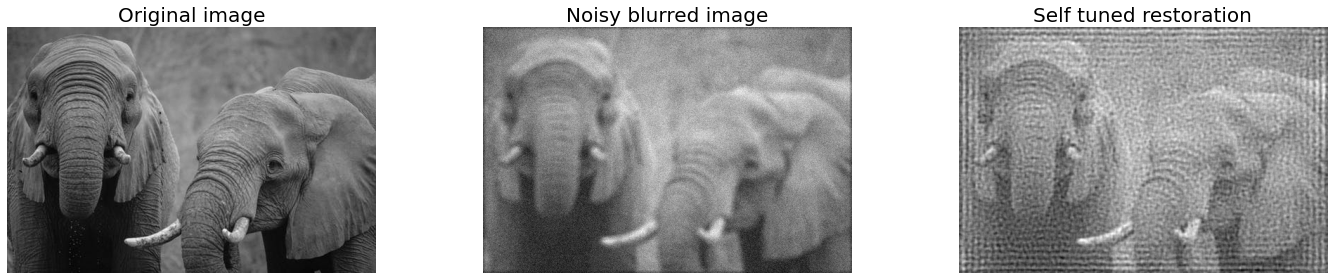

In [28]:
from skimage import color, data, restoration
im = color.rgb2gray(imread('../images/elephant_g.jpg'))
from scipy.signal import convolve2d as conv2
n = 9
psf = np.ones((n, n)) / n**2
im1 = conv2(im, psf, 'same')
#im1 = conv2(im,mblur_kernel)
im1 += 0.3 * im1.std() * np.random.standard_normal(im1.shape)
im2, _ = restoration.unsupervised_wiener(im1, psf)
fig, axes = pylab.subplots(nrows=1, ncols=3, figsize=(20, 4), sharex=True, sharey=True)
pylab.gray()
axes[0].imshow(im), axes[0].axis('off'), axes[0].set_title('Original image', size=20)
axes[1].imshow(im1), axes[1].axis('off'), axes[1].set_title('Noisy blurred image', size=20)
axes[2].imshow(im2), axes[2].axis('off'), axes[2].set_title('Self tuned restoration', size=20)
fig.tight_layout()
pylab.show()

### Image denoising with FFT

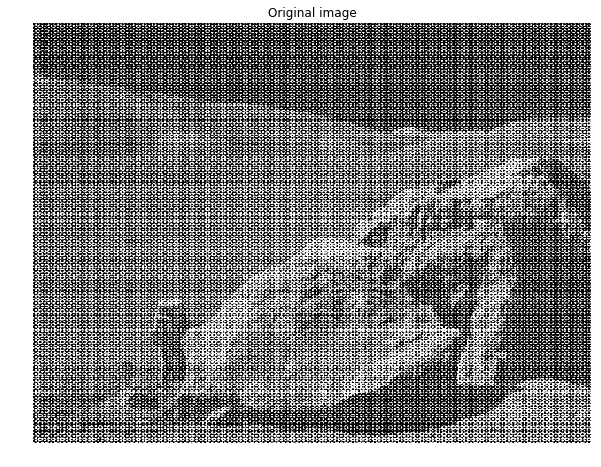

(<matplotlib.image.AxesImage at 0x1a6deacb278>,
 (-0.5, 629.5, 473.5, -0.5),
 None)

In [30]:
im = pylab.imread('../images/moonlanding.png').astype(float)
pylab.figure(figsize=(10,10))
pylab.imshow(im, pylab.cm.gray), pylab.axis('off'), pylab.title('Original image'), pylab.show()

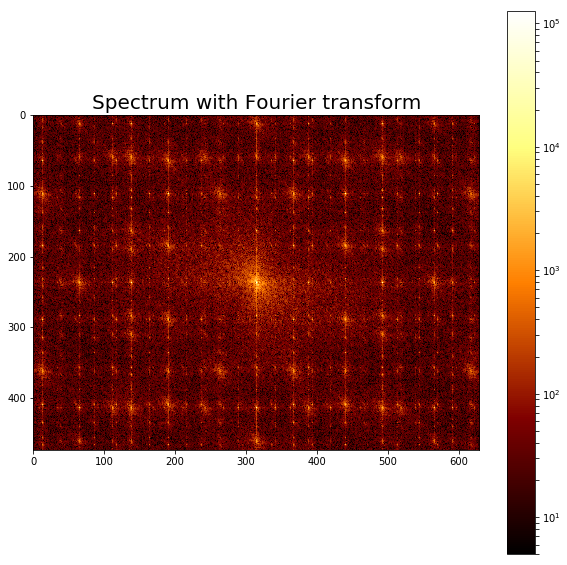

In [31]:
from scipy import fftpack
from matplotlib.colors import LogNorm
im_fft = fftpack.fft2(im)
def plot_spectrum(im_fft):
    pylab.figure(figsize=(10,10))
    pylab.imshow(np.abs(im_fft), norm=LogNorm(vmin=5), cmap=pylab.cm.afmhot), pylab.colorbar()
pylab.figure(), plot_spectrum(fftpack.fftshift(im_fft))
pylab.title('Spectrum with Fourier transform', size=20)

### Filter in FFT

(<matplotlib.figure.Figure at 0x1a6df3ca278>,
 None,
 <matplotlib.text.Text at 0x1a6defff780>)

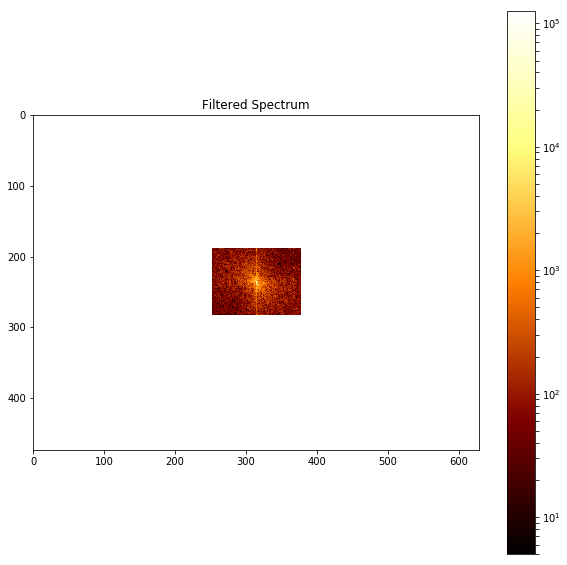

In [32]:
# Copy the original spectrum and truncate coefficients.
# Define the fraction of coefficients (in each direction) to keep as
keep_fraction = 0.1
im_fft2 = im_fft.copy()
# Set r and c to the number of rows and columns of the array.
r, c = im_fft2.shape
# Set all rows to zero with indices between r*keep_fraction and r*(1-keep_fraction)
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
# Similarly with the columns
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
pylab.figure(), plot_spectrum(fftpack.fftshift(im_fft2)),pylab.title('Filtered Spectrum')

### Reconstructing the final image

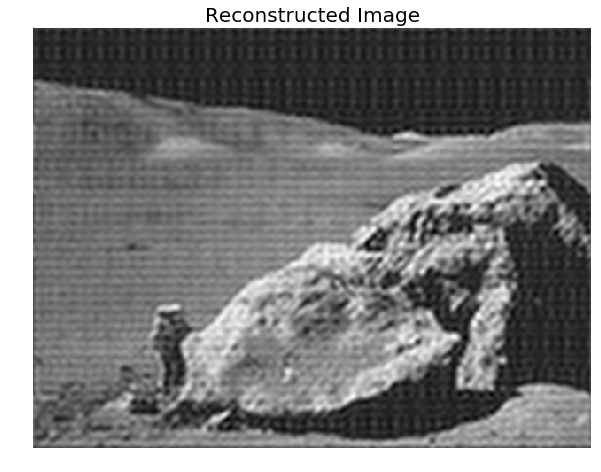

In [33]:
# Reconstruct the denoised image from the filtered spectrum, keep only the real part for display.
im_new = fp.ifft2(im_fft2).real
pylab.figure(figsize=(10,10)), pylab.imshow(im_new, pylab.cm.gray),
pylab.axis('off')
pylab.title('Reconstructed Image', size=20)

### Wiener Filter

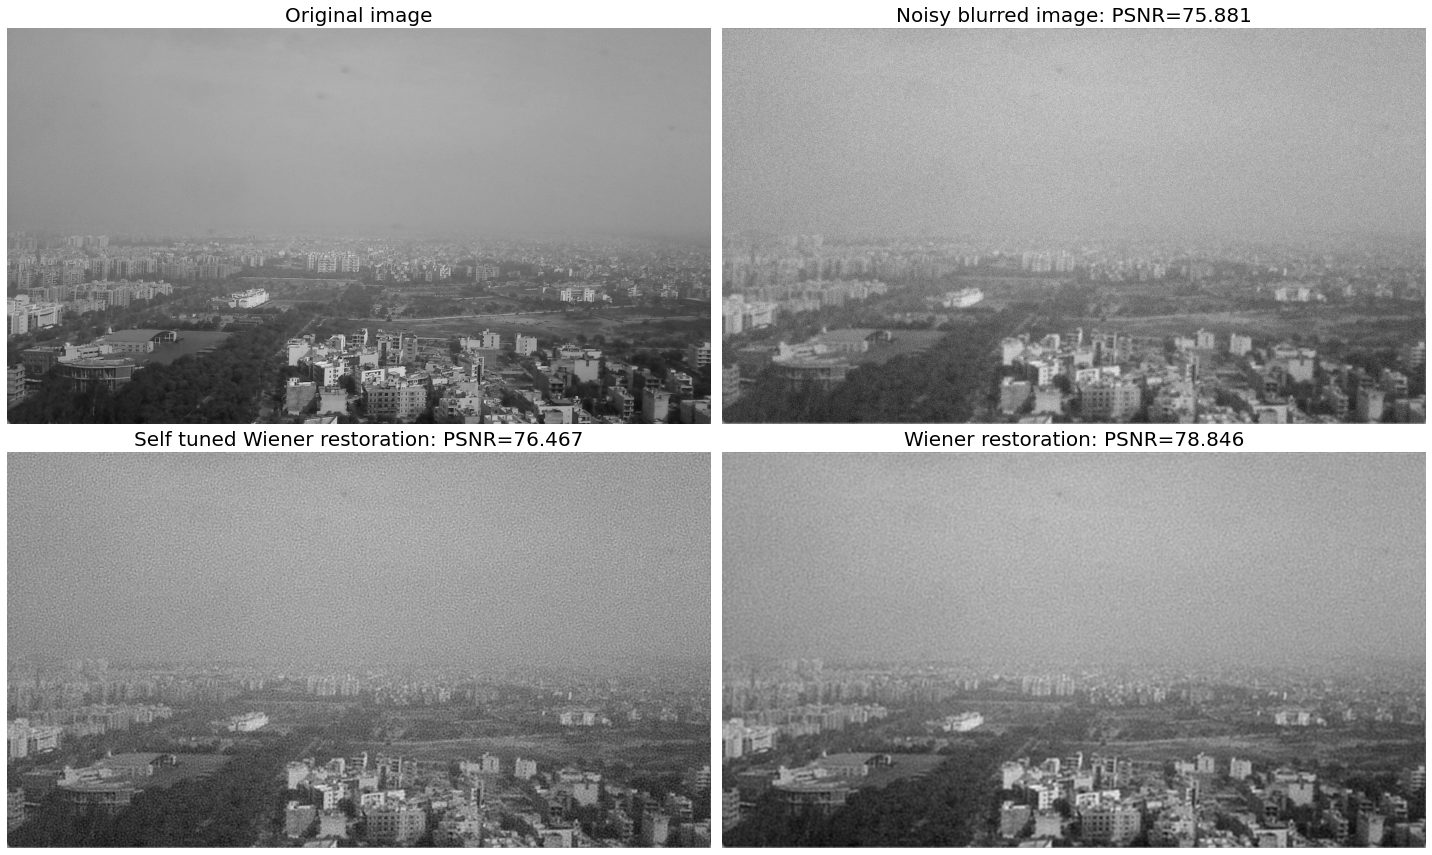

In [30]:
%matplotlib inline
from skimage import color, data, restoration
import scipy.fftpack as fp
from skimage.io import imread
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def convolve2d(im, psf, k):
    M, N = im.shape
    freq = fp.fft2(im)
    psf = np.pad(psf, (((M-k)//2,(M-k)//2+1), ((N-k)//2,(N-k)//2+1)), mode='constant') # assumption: min(M,N) > k > 0, k odd
    freq_kernel = fp.fft2(fp.ifftshift(psf))
    return np.abs(fp.ifft2(freq*freq_kernel))

def plot_freq_filter(F, title, size=20):
    plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(F))), cmap='coolwarm'), plt.title(title, size=size), plt.colorbar()

def plot_freq_spec_3d(freq):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    Y = np.arange(-freq.shape[0]//2,freq.shape[0]-freq.shape[0]//2)
    X = np.arange(-freq.shape[1]//2,freq.shape[1]-freq.shape[1]//2)
    X, Y = np.meshgrid(X, Y)
    Z = (20*np.log10( 0.01 + fp.fftshift(freq))).real
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                           linewidth=0, antialiased=True)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    plt.show()

im = color.rgb2gray(imread('../images/earth_from_sky.png'))
k = 5
psf = np.ones((k, k)) / k**2
im1 = convolve2d(im, psf, k)
im1 += 0.3 * im.std() * np.random.standard_normal(im.shape)
im2, _ = restoration.unsupervised_wiener(im1, psf)
im3 = restoration.wiener(im1, psf, balance=0.25)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12), sharex=True, sharey=True)
plt.gray()
axes[0,0].imshow(im), axes[0,0].axis('off'), axes[0,0].set_title('Original image', size=20)
axes[0,1].imshow(im1), axes[0,1].axis('off'), axes[0,1].set_title('Noisy blurred image: PSNR={:.3f}'.format(compare_psnr(im, im1)), size=20)
axes[1,0].imshow(im2), axes[1,0].axis('off'), axes[1,0].set_title('Self tuned Wiener restoration: PSNR={:.3f}'.format(compare_psnr(im, im2)), size=20)
axes[1,1].imshow(im3), axes[1,1].axis('off'), axes[1,1].set_title('Wiener restoration: PSNR={:.3f}'.format(compare_psnr(im, im3)), size=20)
fig.tight_layout()
plt.show()

C:\Users\0109491s\AppData\Local\Temp/ipykernel_25768/2878548088.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


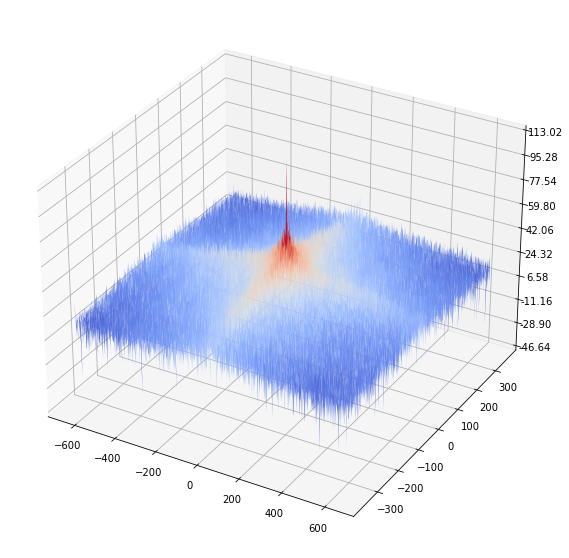

In [26]:
plot_freq_spec_3d(fp.fft2(im))

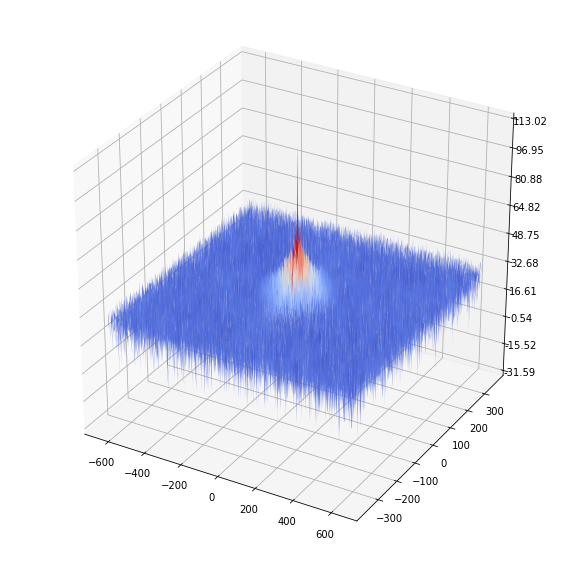

In [22]:
plot_freq_spec_3d(fp.fft2(im1))

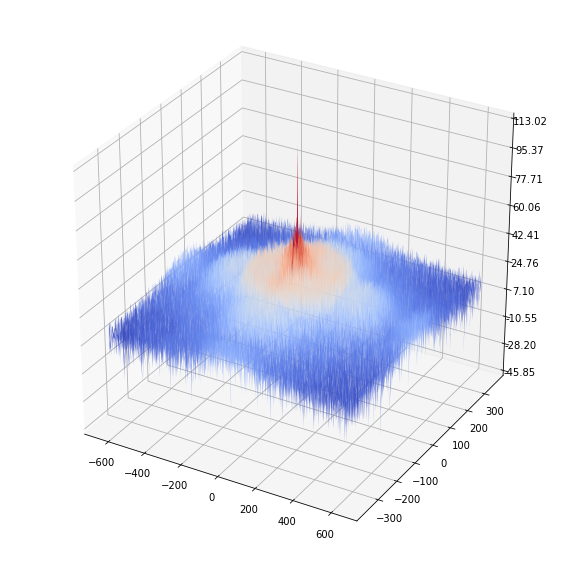

In [23]:
plot_freq_spec_3d(fp.fft2(im2))

In [24]:
plot_freq_spec_3d(fp.fft2(im3))

### Constrained Least Squares (CLS) Filter

(720, 540)
1.0


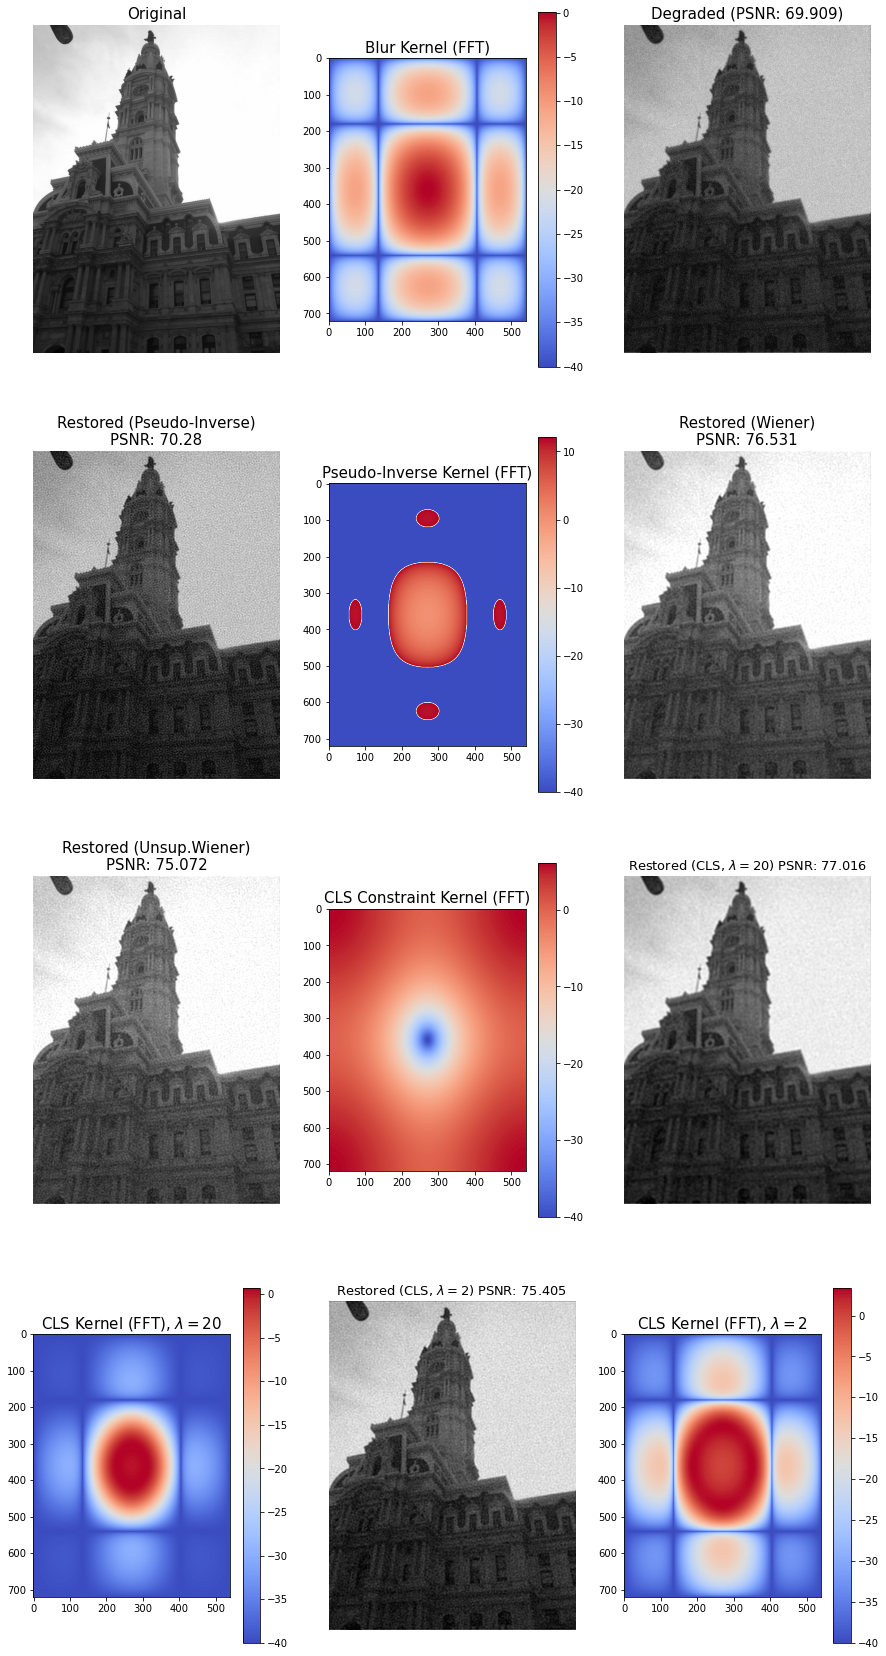

In [34]:
import numpy as np
import scipy.fftpack as fp
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.restoration import wiener, unsupervised_wiener
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

def pseudo_inverse_filter(y, h, epsilon):
    '''
    Hinv(u,v) = 1/H(u,v)   if |H(u,v)| > epsilon
                0          otherwise
    '''
    Hf = fp.fft2(fp.ifftshift(h))
    M, N = Hf.shape
    Hf[(np.abs(Hf)<epsilon)] = 0
    indices = np.where((np.abs(Hf)>=epsilon))
    Hf[indices] = np.ones((M,N))[indices] / Hf[indices]
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return (im, Hf)

def cls_filter(y,h,c,lambd):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf = np.conj(Hf) / (Hf*np.conj(Hf) + lambd*Cf*np.conj(Cf))
    #Hf = np.abs(Hf)**2 / (np.abs(Hf)**2 + lambd*np.abs(Cf)**2)
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return (im, Hf) 

# Input and display the binary image
x = rgb2gray(imread('../images/building2.png'))
print(x.shape)
M, N = x.shape
print(np.max(x))

plt.figure(figsize=(15,30))

plt.subplot(431), plt.imshow(x, cmap='gray'), plt.axis('off'), plt.title('Original', size=15)

# Blur the image, corrupt the image using WGN and display it
# h is the blurring filter, and sigma is the noise std
h = np.ones((4,4))/16
h = np.pad(h, [(M//2-2, M//2-2), (N//2-2, N//2-2)], mode='constant')
sigma = 0.075
Xf = fp.fft2(x)
Hf = fp.fft2(fp.ifftshift(h))

plt.subplot(432), plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'), plt.title('Blur Kernel (FFT)', size=15), plt.colorbar()

Y = Hf*Xf
y = fp.ifft2(Y).real + sigma*np.random.normal(size=(M,N))

plt.subplot(433), plt.imshow(np.abs(y), cmap='gray'), plt.axis('off'), plt.title('Degraded (PSNR: {})'.format(np.round(compare_psnr(x, y),3)), size=15)

# restoration using inverse filtering
epsilon = 0.25
pix, F_pseudo = pseudo_inverse_filter(y, h, epsilon)
plt.subplot(434), plt.imshow(pix, cmap='gray'), plt.axis('off'), plt.title('Restored (Pseudo-Inverse)\nPSNR: {}'.format(np.round(compare_psnr(x, pix),3)), size=15)
plt.subplot(435), plot_freq_filter(F_pseudo, 'Pseudo-Inverse Kernel (FFT)', size=15)

# restoration using wiener filtering
wx = wiener(y, h, balance=0.25)
plt.subplot(436), plt.imshow(wx, cmap='gray'), plt.axis('off'), plt.title('Restored (Wiener)\nPSNR: {}'.format(np.round(compare_psnr(x, wx),3)), size=15)

# restoration using unsupervised wiener filtering
uwx, _ = unsupervised_wiener(y, h)
plt.subplot(437), plt.imshow(uwx, cmap='gray'), plt.axis('off'), plt.title('Restored (Unsup.Wiener)\nPSNR: {}'.format(np.round(compare_psnr(x, uwx),3)), size=15)

# restoration using cls filtering
c =  np.array([[0,1/4,0],[1/4,-1,1/4],[0,1/4,0]])
c = np.pad(c, [(M//2-1, M//2-2), (N//2-2, N//2-1)], mode='constant')
Cf = fp.fft2(fp.ifftshift(c))
plt.subplot(438), plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Cf))), cmap='coolwarm'), plt.title('CLS Constraint Kernel (FFT)', size=15), plt.colorbar()
lambd = 20
clx, F_restored = cls_filter(y, h, c, lambd)
plt.subplot(439), plt.imshow(clx, cmap='gray'), plt.axis('off'), plt.title(r'Restored (CLS, $\lambda=${}) PSNR: {}'.format(lambd, np.round(compare_psnr(x, clx),3)), size=13)
plt.subplot(4,3,10), plot_freq_filter(F_restored, r'CLS Kernel (FFT), $\lambda=${}'.format(lambd), size=15)
lambd = 2
clx, F_restored = cls_filter(y, h, c, lambd)
plt.subplot(4,3,11), plt.imshow(clx, cmap='gray'), plt.axis('off'), plt.title(r'Restored (CLS, $\lambda=${}) PSNR: {}'.format(lambd, np.round(compare_psnr(x, clx),3)), size=13)
plt.subplot(4,3,12), plot_freq_filter(F_restored, r'CLS Kernel (FFT), $\lambda=${}'.format(lambd), size=15)

plt.show()

C:\Users\0109491s\AppData\Local\Temp/ipykernel_25768/2595273923.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


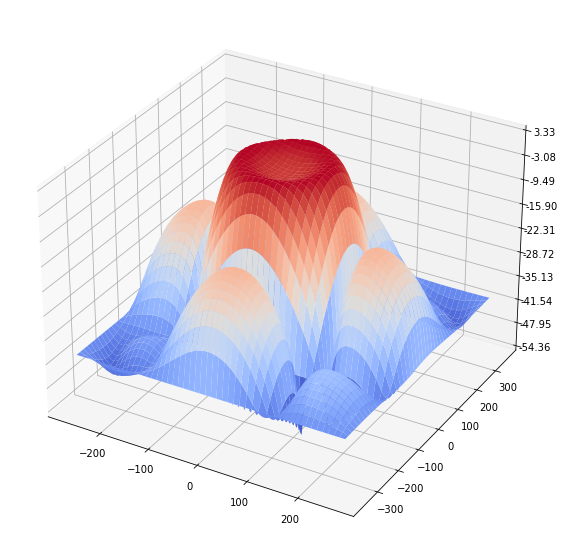

In [35]:
#freq_kernel = np.conj(Hf) / (Hf*np.conj(Hf) + alpha*Cf*np.conj(Cf))      
plot_freq_spec_3d(F_restored)

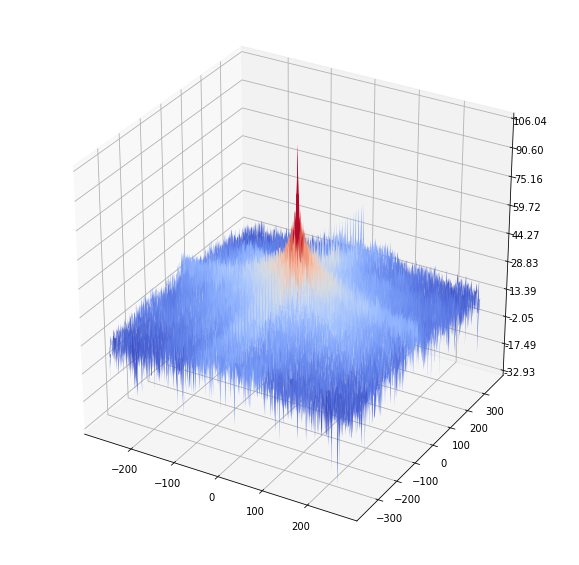

In [27]:
plot_freq_spec_3d(fp.fft2(x))

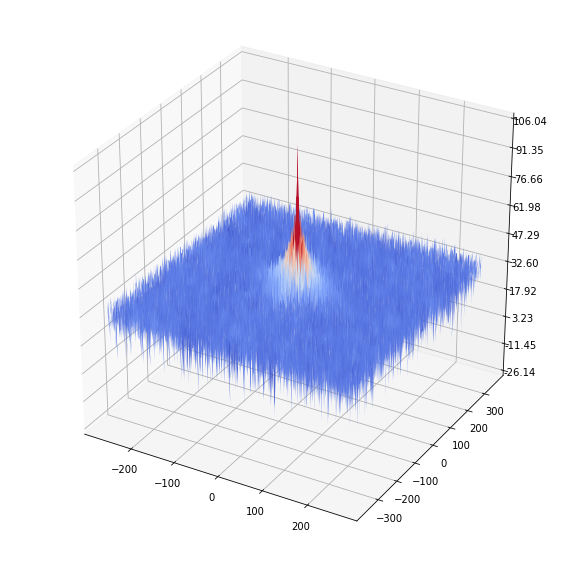

In [28]:
plot_freq_spec_3d(fp.fft2(y))

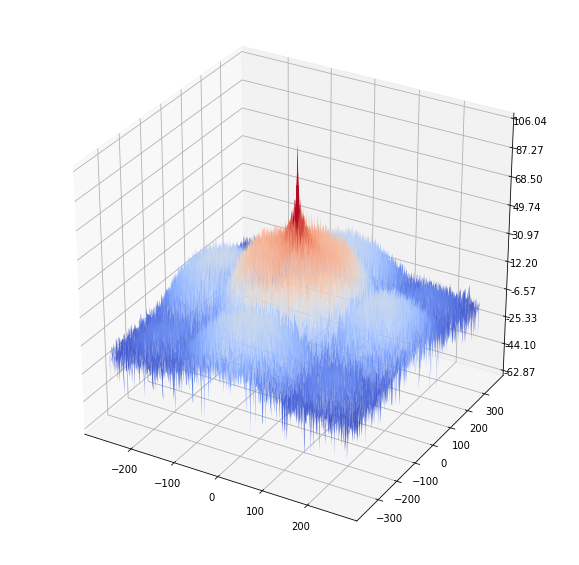

In [29]:
plot_freq_spec_3d(fp.fft2(clx))

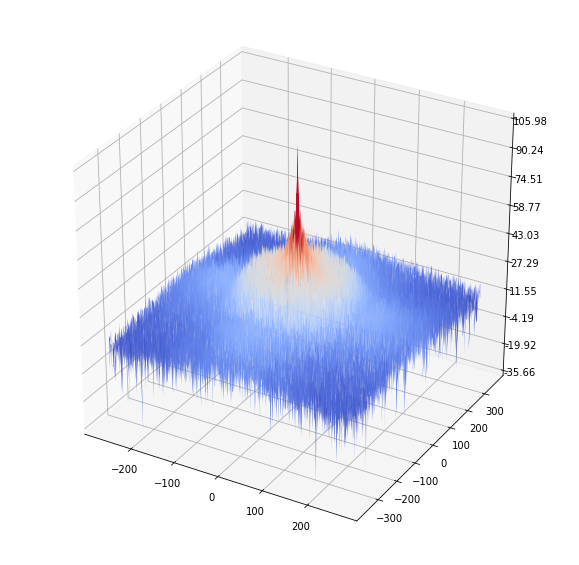

In [30]:
plot_freq_spec_3d(fp.fft2(uwx))

## Restore detail after motion blur

(334, 510) (15, 15)


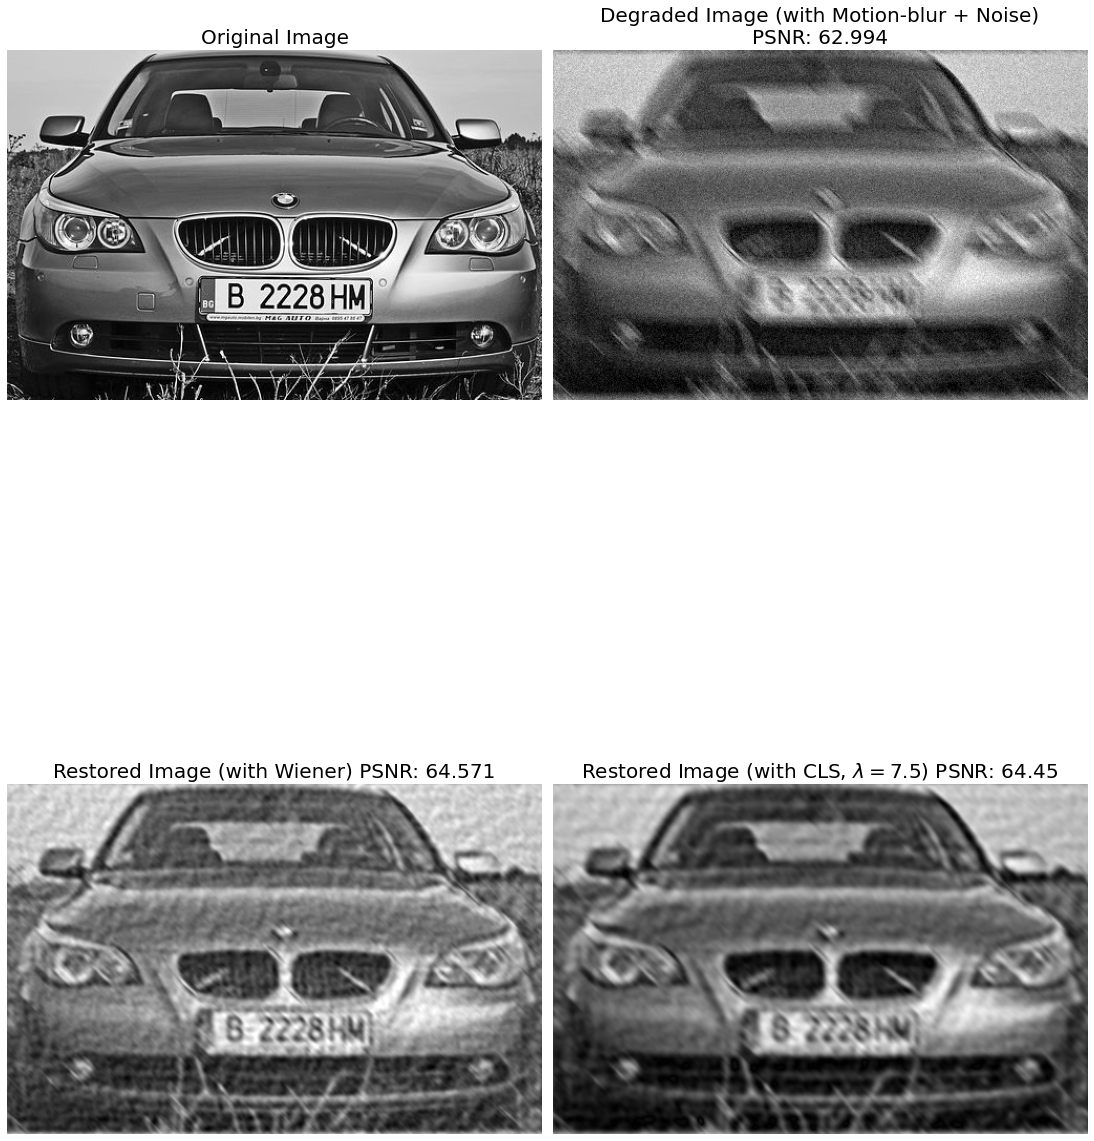

In [41]:
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.io import imread
im = rgb2gray(imread('../images/car.png')) # street
(M, N), k = im.shape, 81 # a 21 x 21 motion blurred kernel

k=15
kernel = np.zeros((k, k))
for i in range(k):
    kernel[i, i] = 1
kernel = kernel / k
#print(kernel)
print(im.shape, kernel.shape)
im_blur = convolve2d(im, kernel, k) #, mode='same')
im_blur = random_noise(im_blur, var=0.0025)

from skimage.restoration import wiener, unsupervised_wiener

def cls_filter(y,h,c,lambd):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf = np.conj(Hf) / (Hf*np.conj(Hf) + lambd*Cf*np.conj(Cf))
    #Hf = np.abs(Hf)**2 / (np.abs(Hf)**2 + lambd*np.abs(Cf)**2)
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return (im, Hf) 

x = im
y = im_blur
h = kernel

h = np.pad(h, [(M//2-k//2, M//2-k//2-1), (N//2-k//2, N//2-k//2-1)], mode='constant')

# restoration using wiener filtering
wx = wiener(y, h, balance=0.1)
# restoration using cls filtering
c =  np.array([[0,1/4,0],[1/4,-1,1/4],[0,1/4,0]])
c = np.pad(c, [(M//2-1, M//2-2), (N//2-2, N//2-1)], mode='constant')
Cf = fp.fft2(fp.ifftshift(c))
lambd = 7.5
clx, F_restored = cls_filter(y, h, c, lambd)

plt.figure(figsize=(15,20))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.02,0.04)
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(222), plt.imshow(im_blur), plt.axis('off'), plt.title('Degraded Image (with Motion-blur + Noise)\nPSNR: {}'.format(np.round(compare_psnr(x, y),3)), size=20)
plt.subplot(223), plt.imshow(wx), plt.axis('off'), plt.title('Restored Image (with Wiener) PSNR: {}'.format(np.round(compare_psnr(x, wx),3)), size=20)
plt.subplot(224), plt.imshow(clx), plt.axis('off'), plt.title(r'Restored Image (with CLS, $\lambda=${}) PSNR: {}'.format(lambd, np.round(compare_psnr(x, clx),3)), size=20)
plt.show()

### Noisy Image Restoration with Markov Random Field

Completed 0 iterations out of 655360
Completed 100000 iterations out of 655360
Completed 200000 iterations out of 655360
Completed 300000 iterations out of 655360
Completed 400000 iterations out of 655360
Completed 500000 iterations out of 655360
Completed 600000 iterations out of 655360


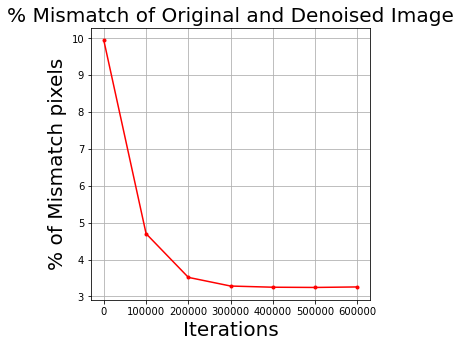

Percentage of mismatched pixels:  3.26080322265625


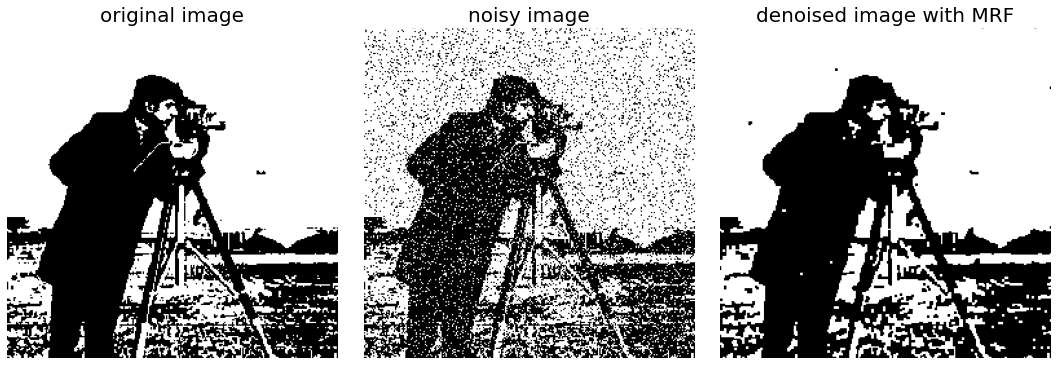

In [39]:
%matplotlib inline
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pylab as plt

def plot_image(im, title):
  im = im.copy()
  im[im==-1] = 0
  im[im==1] = 255
  plt.imshow(im), plt.axis('off'), plt.title(title, size=20)

def plot_error(iters, errors):
    plt.figure(figsize=(5,5))
    plt.plot(iters, errors, 'r.-')
    plt.xlabel('Iterations', size=20)
    plt.ylabel('% of Mismatch pixels', size=20)
    plt.title('% Mismatch of Original and Denoised Image', size=20)
    plt.grid()
    plt.show()

def plot_images(orig_image, noisy_image, denoised_image):
    plt.figure(figsize=(15,5))
    plt.gray()
    plt.subplot(131), plot_image(orig_image, 'original image')
    plt.subplot(132), plot_image(noisy_image, 'noisy image')
    plt.subplot(133), plot_image(denoised_image, 'denoised image with MRF')
    plt.tight_layout()
    plt.show()
    
# preprocessing step
def read_image_and_binarize(image_file, threshold=128):
  im = (255*rgb2gray(plt.imread(image_file))).astype(int)
  im[im < threshold] = -1
  im[im >= threshold] = 1
  return im

def add_noise(im):
  im_noisy = im.copy()
  for i in range(im_noisy.shape[0]):
    for j in range(im_noisy.shape[1]):
      r = np.random.rand()
      if r < 0.1:
        im_noisy[i][j] = -im_noisy[i][j]
  return im_noisy

def compute_energy_helper(Y, i, j):
  try:
    return Y[i][j]
  except IndexError:
    return 0

def compute_energy(X, Y, i, j, zeta, eta, Y_i_j):
  energy = -eta * X[i][j] * Y_i_j #np.sum(X*Y) #
  for (k, l) in [(-1,0),(1,0),(0,-1),(0,1)]:
      energy -= zeta * Y_i_j * compute_energy_helper(Y, i+k, j+l)
  return energy

def denoise_image(O, X, zeta, eta):
  m, n = np.shape(X)
  Y = np.copy(X)
  max_iter = 10*m*n
  iters = []
  errors = []
  for iter in range(max_iter):
    # randomly pick a location
    i = np.random.randint(m)
    j = np.random.randint(n)
    # compute energies for Y_ij = +1 and -1
    energy_neg = compute_energy(X, Y, i, j, zeta, eta, -1)
    energy_pos = compute_energy(X, Y, i, j, zeta, eta, 1)
    # assign Y_ij to the value with min energy
    if energy_neg < energy_pos:
      Y[i][j] = -1
    else:
      Y[i][j] = 1
    if iter % 100000 == 0:
        print ('Completed', iter, 'iterations out of', max_iter)
        error = get_mismatched_percentage(O, Y)
        iters.append(iter)
        errors.append(error)
  plot_error(iters, errors)
  
  return Y

def get_mismatched_percentage(orig_image, denoised_image):
  diff = (orig_image != denoised_image)
  return (100.0 * np.sum(diff)) / np.size(orig_image)

orig_image = read_image_and_binarize('../images/cameraman.png')
zeta = 1.5
eta = 2

# add noise
noisy_image = add_noise(orig_image)

# use ICM for denoising
denoised_image = denoise_image(orig_image, noisy_image, zeta, eta)

# print the percentage of mismatched pixels
print ('Percentage of mismatched pixels: ', get_mismatched_percentage(orig_image, denoised_image))

plot_images(orig_image, noisy_image, denoised_image)